In [ ]:
import os
import zipfile
import urllib.request

# Download the GloVe embeddings
glove_url = "https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/models/glove_100d_en_2.4.0_2.4_1579690104032.zip"
glove_zip = "glove_100d_en_2.4.0_2.4_1579690104032.zip"

# Download the file
urllib.request.urlretrieve(glove_url, glove_zip)

# Unzip the file
with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

# Verify the files are extracted
os.listdir(".")

# Lab | Sequence Modeling with LSTM

In [4]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16 #the max length can be changed, but as higher the length the bigger the sequence, and higher the computational costs
trunc_type='post' #if the sequence is longer than the max_length, it truncates it at the end of the sequence
padding_type='post' #if the sequence is smaller than the max_length, it adds at the end of the sequence
oov_tok = "<OOV>"  #out of vocabulary token
training_size= 160000
#Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion=.1



In [5]:
#!wget --no-check-certificate \
    #https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    #-O /tmp/training_cleaned.csv

corpus = [] #initialize empty corpus

num_sentences = 0

with open("./training.1600000.processed.noemoticon.csv", encoding='utf-8', errors='replace') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        # YOUR CODE HERE
        if len(row)==6:
          list_item = [row[5]]
          item_label = row[0]
          list_item.append(0 if item_label == '0' else 1)
          num_sentences = num_sentences + 1
          corpus.append(list_item)


In [6]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [7]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0]) # grabs the text from the corpus which is on the first column
    labels.append(corpus[x][1]) # grabs the label from the corpus which is on the second column


tokenizer = Tokenizer()

tokenizer.fit_on_texts(sentences) # YOUR CODE HERE

word_index = tokenizer.word_index
vocab_size=len(word_index) # YOUR CODE HERE

sequences = tokenizer.texts_to_sequences(sentences) # YOUR CODE HERE
padded = pad_sequences(sequences, maxlen=max_length, padding = padding_type, truncating=trunc_type) # YOUR CODE HERE

split = int(test_portion * training_size)

test_sequences = padded[0:split] # YOUR CODE HERE
training_sequences = padded[split:training_size] # YOUR CODE HERE
test_labels = labels[0:split] # YOUR CODE HERE
training_labels = labels[split:training_size] # YOUR CODE HERE


In [8]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138482
1


In [9]:
print(test_sequences.shape)
print(training_sequences.shape)

(16000, 16)
(144000, 16)


In [10]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
# wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#     -O /tmp/glove.6B.100d.txt

embeddings_index = {}
with open('./glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [11]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138483


In [14]:
from tensorflow.keras.regularizers import l2

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 100)           13848300  
                                                                 
 dropout_4 (Dropout)         (None, 16, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 16, 128)           117248    
                                                                 
 dropout_5 (Dropout)         (None, 16, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                

<Figure size 640x480 with 0 Axes>

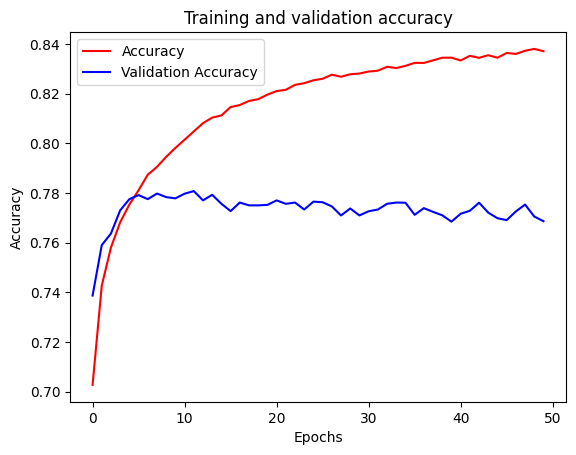

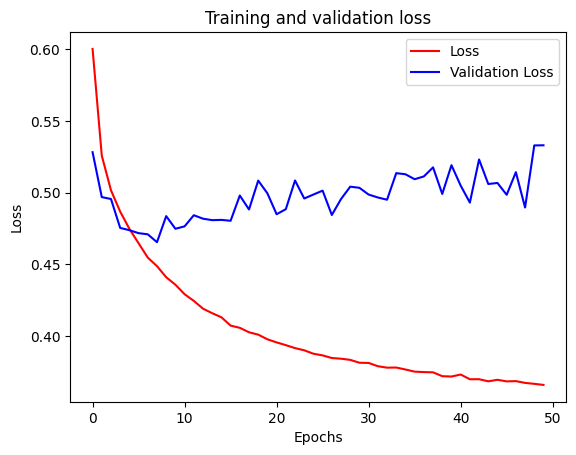

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!